# CS 520 Data Curation Project - ETL Pipeline using Spark, Pandas and MongoDB

## Our goal for the project is to Extract data from a CSV file. 
## Transform the original schema of the file into the required schema with lesser number of columns and with column names changed. 
## Explore and Query the Data. 
## Load the data as JSON Documents in a Mongo-DB JSON Table. 
## All this is done using Spark and Pandas in Python.



## We have used the Medicare Open payments data from a CSV file.
## Requirements: Python, Spark, JupyterNotebook, MongoDB Connection.

## Easy way to install spark for jupyter notebook if not already present 

In [ ]:
import sys
!{sys.executable} -m pip install pyspark

## Importing SparkSession

In [1]:
from pyspark.sql import SparkSession

## Building SparkSession 

In [2]:
spark = SparkSession.builder.appName('CS 520').getOrCreate()

## reading the csv File 

In [3]:
df = spark.read.csv("payments.csv", header = True)

## Print the original schema 

In [10]:
df.printSchema()

root
 |-- Change_Type: string (nullable = true)
 |-- Covered_Recipient_Type: string (nullable = true)
 |-- Teaching_Hospital_CCN: string (nullable = true)
 |-- Teaching_Hospital_ID: string (nullable = true)
 |-- Teaching_Hospital_Name: string (nullable = true)
 |-- Physician_Profile_ID: string (nullable = true)
 |-- Physician_First_Name: string (nullable = true)
 |-- Physician_Middle_Name: string (nullable = true)
 |-- Physician_Last_Name: string (nullable = true)
 |-- Physician_Name_Suffix: string (nullable = true)
 |-- Recipient_Primary_Business_Street_Address_Line1: string (nullable = true)
 |-- Recipient_Primary_Business_Street_Address_Line2: string (nullable = true)
 |-- Recipient_City: string (nullable = true)
 |-- Recipient_State: string (nullable = true)
 |-- Recipient_Zip_Code: string (nullable = true)
 |-- Recipient_Country: string (nullable = true)
 |-- Recipient_Province: string (nullable = true)
 |-- Recipient_Postal_Code: string (nullable = true)
 |-- Physician_Primary_Ty

## Changing the data type of Amount from String to Double  

In [11]:
from pyspark.sql.types import DoubleType


In [12]:
df2 = df.withColumn("amount" , df["Total_Amount_of_Payment_USDollars"].cast(DoubleType()))

## Creating a Temporary Payments 

In [13]:
df2.createGlobalTempView("payments1")

## We can also specify the schema while importing the file in the below manner 

In [14]:
from pyspark.sql.types import StructField,StringType,IntegerType,StructType

In [15]:
data_schema = [StructField("physician_id", StringType(), True),StructField("date_payment", StringType(), True),StructField("record_id", StringType(), True),StructField("payer", StringType(), True),StructField("amount", DoubleType(), True),StructField("physician_speciality", StringType(), True),StructField("nature_of_payment", StringType(), True)]

In [16]:
final_struc = StructType(fields=data_schema)

## Selecting only the columns we want and also renaming the Columns as we want 

In [94]:
ds = spark.sql("select Physician_Profile_ID as physician_id,Recipient_Primary_Business_Street_Address_Line1 as Address_1,Recipient_Primary_Business_Street_Address_Line2 as Address_2,Recipient_City as City, Recipient_State as State,Recipient_Zip_Code as ZipCode, Date_of_Payment as date_payment, Record_ID as record_id, Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name as payer,amount, Physician_Specialty, Nature_of_Payment_or_Transfer_of_Value as Nature_of_payment from global_temp.payments1 where Physician_Profile_ID IS NOT NULL")

## Required Schema 

In [95]:
ds.printSchema()

root
 |-- physician_id: string (nullable = true)
 |-- Address_1: string (nullable = true)
 |-- Address_2: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- ZipCode: string (nullable = true)
 |-- date_payment: string (nullable = true)
 |-- record_id: string (nullable = true)
 |-- payer: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- Physician_Specialty: string (nullable = true)
 |-- Nature_of_payment: string (nullable = true)



In [96]:
ds.first()

Row(physician_id='673985', Address_1='726 FOURTH ST', Address_2=None, City='MARYSVILLE', State='CA', ZipCode='95901', date_payment='01/21/2016', record_id='346039414', payer='DFINE, Inc', amount=286.2, Physician_Specialty='Allopathic & Osteopathic Physicians|Anesthesiology', Nature_of_payment='Travel and Lodging')

## Replacing the temporary view with our new view 

In [97]:
ds.createOrReplaceGlobalTempView("payments")

## Sample data 

In [98]:
ds.show()

+------------+--------------------+----------+-----------+-----+-------+------------+---------+----------+------+--------------------+------------------+
|physician_id|           Address_1| Address_2|       City|State|ZipCode|date_payment|record_id|     payer|amount| Physician_Specialty| Nature_of_payment|
+------------+--------------------+----------+-----------+-----+-------+------------+---------+----------+------+--------------------+------------------+
|      673985|       726 FOURTH ST|      null| MARYSVILLE|   CA|  95901|  01/21/2016|346039414|DFINE, Inc| 286.2|Allopathic & Oste...|Travel and Lodging|
|      673985|       726 FOURTH ST|      null| MARYSVILLE|   CA|  95901|  01/21/2016|346039416|DFINE, Inc|  25.0|Allopathic & Oste...|Travel and Lodging|
|      673985|       726 FOURTH ST|      null| MARYSVILLE|   CA|  95901|  02/19/2016|346039418|DFINE, Inc| 27.27|Allopathic & Oste...|Travel and Lodging|
|       93975|        9601 LILE DR|SUITE 1100|LITTLE ROCK|   AR|  72205|  04

## Filling null values in Address_2 with space 

In [99]:
ds = ds.na.fill('')

In [100]:
ds.show()

+------------+--------------------+----------+-----------+-----+-------+------------+---------+----------+------+--------------------+------------------+
|physician_id|           Address_1| Address_2|       City|State|ZipCode|date_payment|record_id|     payer|amount| Physician_Specialty| Nature_of_payment|
+------------+--------------------+----------+-----------+-----+-------+------------+---------+----------+------+--------------------+------------------+
|      673985|       726 FOURTH ST|          | MARYSVILLE|   CA|  95901|  01/21/2016|346039414|DFINE, Inc| 286.2|Allopathic & Oste...|Travel and Lodging|
|      673985|       726 FOURTH ST|          | MARYSVILLE|   CA|  95901|  01/21/2016|346039416|DFINE, Inc|  25.0|Allopathic & Oste...|Travel and Lodging|
|      673985|       726 FOURTH ST|          | MARYSVILLE|   CA|  95901|  02/19/2016|346039418|DFINE, Inc| 27.27|Allopathic & Oste...|Travel and Lodging|
|       93975|        9601 LILE DR|SUITE 1100|LITTLE ROCK|   AR|  72205|  04

## Combining Address_1, Address_2, City, State, ZipCode to one column Address 

In [101]:
from pyspark.sql import functions as sf
ds = ds.withColumn('Address', 
                    sf.concat(sf.col('Address_1'),sf.lit(','), sf.col('Address_2'),sf.lit(' '), sf.col('City'),sf.lit(','), sf.col('State'),sf.lit('-'), sf.col('ZipCode')))

In [103]:
ds = ds.drop("Address_1" , "Address_2" , "City", "State", "ZipCode")

In [104]:
ds.show()

+------------+------------+---------+----------+------+--------------------+------------------+--------------------+
|physician_id|date_payment|record_id|     payer|amount| Physician_Specialty| Nature_of_payment|             Address|
+------------+------------+---------+----------+------+--------------------+------------------+--------------------+
|      673985|  01/21/2016|346039414|DFINE, Inc| 286.2|Allopathic & Oste...|Travel and Lodging|726 FOURTH ST, MA...|
|      673985|  01/21/2016|346039416|DFINE, Inc|  25.0|Allopathic & Oste...|Travel and Lodging|726 FOURTH ST, MA...|
|      673985|  02/19/2016|346039418|DFINE, Inc| 27.27|Allopathic & Oste...|Travel and Lodging|726 FOURTH ST, MA...|
|       93975|  04/15/2016|346039420|DFINE, Inc|  21.6|Allopathic & Oste...| Food and Beverage|9601 LILE DR,SUIT...|
|      275444|  04/29/2016|346039422|DFINE, Inc| 22.57|Allopathic & Oste...| Food and Beverage|1214 RICHARDSON S...|
|      132655|  02/05/2016|346039424|DFINE, Inc| 780.7|Allopathi

## Sample first Row 

In [105]:
ds.first()

Row(physician_id='673985', date_payment='01/21/2016', record_id='346039414', payer='DFINE, Inc', amount=286.2, Physician_Specialty='Allopathic & Osteopathic Physicians|Anesthesiology', Nature_of_payment='Travel and Lodging', Address='726 FOURTH ST, MARYSVILLE,CA-95901')

## Changing the type of date from string to date format and also changing format from mm/dd/yyyy to yyyy-mm-dd (unix timestamp) format

In [106]:
from pyspark.sql.functions import to_date
from pyspark.sql.functions import unix_timestamp

ds =ds.withColumn("date_payment", to_date(unix_timestamp(ds["date_payment"], "MM/dd/yyyy").cast("timestamp")))


In [122]:
ds.printSchema()

root
 |-- physician_id: string (nullable = false)
 |-- date_payment: date (nullable = true)
 |-- record_id: string (nullable = false)
 |-- payer: string (nullable = false)
 |-- amount: string (nullable = true)
 |-- Physician_Specialty: string (nullable = false)
 |-- Nature_of_payment: string (nullable = false)
 |-- Address: string (nullable = false)



In [108]:
ds.show()

+------------+------------+---------+----------+------+--------------------+------------------+--------------------+
|physician_id|date_payment|record_id|     payer|amount| Physician_Specialty| Nature_of_payment|             Address|
+------------+------------+---------+----------+------+--------------------+------------------+--------------------+
|      673985|  2016-01-21|346039414|DFINE, Inc| 286.2|Allopathic & Oste...|Travel and Lodging|726 FOURTH ST, MA...|
|      673985|  2016-01-21|346039416|DFINE, Inc|  25.0|Allopathic & Oste...|Travel and Lodging|726 FOURTH ST, MA...|
|      673985|  2016-02-19|346039418|DFINE, Inc| 27.27|Allopathic & Oste...|Travel and Lodging|726 FOURTH ST, MA...|
|       93975|  2016-04-15|346039420|DFINE, Inc|  21.6|Allopathic & Oste...| Food and Beverage|9601 LILE DR,SUIT...|
|      275444|  2016-04-29|346039422|DFINE, Inc| 22.57|Allopathic & Oste...| Food and Beverage|1214 RICHARDSON S...|
|      132655|  2016-02-05|346039424|DFINE, Inc| 780.7|Allopathi

In [109]:
ds.createOrReplaceGlobalTempView("payments")

In [92]:
ds.count()

11258361

## Rounding off amount to one decimal 

In [138]:
from pyspark.sql.functions import format_number


In [139]:
ds = ds.withColumn("amount" , bround(ds["amount"],1))


In [140]:
ds.show()

+------------+------------+---------+----------+------+--------------------+------------------+--------------------+
|physician_id|date_payment|record_id|     payer|amount| Physician_Specialty| Nature_of_payment|             Address|
+------------+------------+---------+----------+------+--------------------+------------------+--------------------+
|      673985|  2016-01-21|346039414|DFINE, Inc| 286.2|Allopathic & Oste...|Travel and Lodging|726 FOURTH ST, MA...|
|      673985|  2016-01-21|346039416|DFINE, Inc|  25.0|Allopathic & Oste...|Travel and Lodging|726 FOURTH ST, MA...|
|      673985|  2016-02-19|346039418|DFINE, Inc|  27.3|Allopathic & Oste...|Travel and Lodging|726 FOURTH ST, MA...|
|       93975|  2016-04-15|346039420|DFINE, Inc|  21.6|Allopathic & Oste...| Food and Beverage|9601 LILE DR,SUIT...|
|      275444|  2016-04-29|346039422|DFINE, Inc|  22.6|Allopathic & Oste...| Food and Beverage|1214 RICHARDSON S...|
|      132655|  2016-02-05|346039424|DFINE, Inc| 780.7|Allopathi

In [141]:
ds.printSchema()

root
 |-- physician_id: string (nullable = false)
 |-- date_payment: date (nullable = true)
 |-- record_id: string (nullable = false)
 |-- payer: string (nullable = false)
 |-- amount: double (nullable = true)
 |-- Physician_Specialty: string (nullable = false)
 |-- Nature_of_payment: string (nullable = false)
 |-- Address: string (nullable = false)



## Sample first row 

In [172]:
ds.first()

Row(physician_id='673985', date_payment=datetime.date(2016, 1, 21), record_id='346039414', payer='DFINE, Inc', amount=286.2, Physician_Specialty='Allopathic & Osteopathic Physicians|Anesthesiology', Nature_of_payment='Travel and Lodging', Address='726 FOURTH ST, MARYSVILLE,CA-95901')

## Querying and Exploring the data  

## Querying can be done in two ways. One by using Spark functions and other directly by writing SQl statements. Both the ways are used below. 

### Top 10 nature of accounts with payments by count  

In [142]:
from pyspark.sql.functions import desc
ds.groupBy(ds["Nature_of_Payment"]).count().orderBy(desc("count")).show(10)

+--------------------+-------+
|   Nature_of_Payment|  count|
+--------------------+-------+
|   Food and Beverage|9975364|
|  Travel and Lodging| 575255|
|Compensation for ...| 251440|
|           Education| 245515|
|      Consulting Fee| 115316|
|                Gift|  41523|
|           Honoraria|  17795|
|  Royalty or License|  11814|
|Compensation for ...|   9171|
|       Entertainment|   8408|
+--------------------+-------+
only showing top 10 rows



### Nature of payments with payments  > $500 with their counts

In [150]:
ds.filter(ds["amount"] > 500.0).groupBy(ds["Nature_of_Payment"]).count().show()

+--------------------+-----+
|   Nature_of_Payment|count|
+--------------------+-----+
|           Education| 3487|
|       Entertainment|   76|
|  Travel and Lodging|79488|
|Charitable Contri...|   35|
|Current or prospe...|   50|
|           Honoraria| 1114|
|               Grant|  268|
|Compensation for ...|   67|
|  Royalty or License|  881|
|Compensation for ...| 2242|
|   Food and Beverage| 2689|
|Compensation for ...|15126|
|      Consulting Fee|13018|
|                Gift| 1034|
+--------------------+-----+



### Top five Physicain specialites by total amount 

In [145]:
from pyspark.sql.functions import sum

In [146]:
spark.sql ("select physician_id , sum(amount) as revenue from global_temp.payments group by physician_id order by revenue desc limit 5").show() 

+------------+--------------------+
|physician_id|             revenue|
+------------+--------------------+
|      288926|       2.183833534E7|
|      311622|1.9940975750000004E7|
|      327184|1.3732734540000003E7|
|      281659|         1.3202939E7|
|       32719|1.2149519940000001E7|
+------------+--------------------+



### Top 10  nature of payments by total amount

In [147]:
spark.sql("select Nature_of_payment , sum(amount) as total from global_temp.payments group by Nature_of_payment order by total desc limit 10").show()

+--------------------+--------------------+
|   Nature_of_payment|               total|
+--------------------+--------------------+
|Compensation for ...| 5.618398276899997E8|
|  Royalty or License| 4.892801498499998E8|
|      Consulting Fee|3.6266093983000004E8|
|   Food and Beverage|2.4166747336000344E8|
|  Travel and Lodging|1.9028856042000213E8|
|Current or prospe...|6.2862144450000025E7|
|           Honoraria|       4.392361441E7|
|           Education| 3.895051414999967E7|
|               Grant|       2.389616791E7|
|Compensation for ...|       2.006624783E7|
+--------------------+--------------------+



## Average amount of payment  in each month 

In [148]:
from pyspark.sql.functions import format_number,dayofmonth,hour,dayofyear,month,year,weekofyear,date_format

In [149]:
ds.groupBy(month(ds['date_payment'])).mean().show()

+-------------------+------------------+
|month(date_payment)|       avg(amount)|
+-------------------+------------------+
|                 12| 40.57908835217251|
|               null|               1.0|
|                  1| 37.19044951294319|
|                  6| 39.80850109903817|
|                  3|40.216438564786664|
|                  5| 40.18545214570404|
|                  9| 39.49735599469411|
|                  4| 41.62322929397568|
|                  8|35.482128729075725|
|                  7| 35.92725206903188|
|                 10|41.045018935882496|
|                 11| 39.72110302852038|
|                  2|  39.0201135756034|
+-------------------+------------------+



## Installing pymongo 

In [ ]:
import sys
!{sys.executable} -m pip install pymongo

In [151]:
ds.show()

+------------+------------+---------+----------+------+--------------------+------------------+--------------------+
|physician_id|date_payment|record_id|     payer|amount| Physician_Specialty| Nature_of_payment|             Address|
+------------+------------+---------+----------+------+--------------------+------------------+--------------------+
|      673985|  2016-01-21|346039414|DFINE, Inc| 286.2|Allopathic & Oste...|Travel and Lodging|726 FOURTH ST, MA...|
|      673985|  2016-01-21|346039416|DFINE, Inc|  25.0|Allopathic & Oste...|Travel and Lodging|726 FOURTH ST, MA...|
|      673985|  2016-02-19|346039418|DFINE, Inc|  27.3|Allopathic & Oste...|Travel and Lodging|726 FOURTH ST, MA...|
|       93975|  2016-04-15|346039420|DFINE, Inc|  21.6|Allopathic & Oste...| Food and Beverage|9601 LILE DR,SUIT...|
|      275444|  2016-04-29|346039422|DFINE, Inc|  22.6|Allopathic & Oste...| Food and Beverage|1214 RICHARDSON S...|
|      132655|  2016-02-05|346039424|DFINE, Inc| 780.7|Allopathi

## Converting the pyspark dataframe to RDD of JSON Object 

In [152]:

    
import json

results =ds.toJSON()
    

## Sample RDD 

## As the dataset is too big, there are a lot of memory issues which we were facing. So we have decided to use only top 50000 rows. In a bigger environment, same method can be used for bigger datasets. 

In [154]:
ds2 = spark.sql("select * from global_temp.payments limit 50000")

In [155]:
ds2.show()

+------------+------------+---------+----------+------+--------------------+------------------+--------------------+
|physician_id|date_payment|record_id|     payer|amount| Physician_Specialty| Nature_of_payment|             Address|
+------------+------------+---------+----------+------+--------------------+------------------+--------------------+
|      673985|  2016-01-21|346039414|DFINE, Inc| 286.2|Allopathic & Oste...|Travel and Lodging|726 FOURTH ST, MA...|
|      673985|  2016-01-21|346039416|DFINE, Inc|  25.0|Allopathic & Oste...|Travel and Lodging|726 FOURTH ST, MA...|
|      673985|  2016-02-19|346039418|DFINE, Inc| 27.27|Allopathic & Oste...|Travel and Lodging|726 FOURTH ST, MA...|
|       93975|  2016-04-15|346039420|DFINE, Inc|  21.6|Allopathic & Oste...| Food and Beverage|9601 LILE DR,SUIT...|
|      275444|  2016-04-29|346039422|DFINE, Inc| 22.57|Allopathic & Oste...| Food and Beverage|1214 RICHARDSON S...|
|      132655|  2016-02-05|346039424|DFINE, Inc| 780.7|Allopathi

In [156]:
from pyspark import SparkContext, SparkConf

## Converting pyspark dataframe to pandas dataframe 

In [157]:
import pandas as pd

In [158]:
pdDf = ds2.toPandas()

## Sample pandas data frame 

In [159]:
pdDf.head()

,physician_id,date_payment,record_id,payer,amount,Physician_Specialty,Nature_of_payment,Address
0,673985,2016-01-21,346039414,"DFINE, Inc",286.20,Allopathic & Osteopathic Physicians|Anesthesio...,Travel and Lodging,"726 FOURTH ST, MARYSVILLE,CA-95901"
1,673985,2016-01-21,346039416,"DFINE, Inc",25.00,Allopathic & Osteopathic Physicians|Anesthesio...,Travel and Lodging,"726 FOURTH ST, MARYSVILLE,CA-95901"
2,673985,2016-02-19,346039418,"DFINE, Inc",27.27,Allopathic & Osteopathic Physicians|Anesthesio...,Travel and Lodging,"726 FOURTH ST, MARYSVILLE,CA-95901"
3,93975,2016-04-15,346039420,"DFINE, Inc",21.60,Allopathic & Osteopathic Physicians|Radiology|...,Food and Beverage,"9601 LILE DR,SUITE 1100 LITTLE ROCK,AR-72205"
4,275444,2016-04-29,346039422,"DFINE, Inc",22.57,Allopathic & Osteopathic Physicians|Internal M...,Food and Beverage,"1214 RICHARDSON ST, PORT HURON,MI-48060"


## Creating a new index as physician_id+date_payment+Nature_of_payment so that it is easier to query and find records in the database

In [160]:
pdDf = pdDf.set_index([pdDf.physician_id+'_'+ pdDf.Nature_of_payment])

pdDf['date_payment'] = pdDf['date_payment'].astype(str)
pdDf = pdDf.set_index([pdDf.physician_id+'_'+'_'+pdDf.date_payment+'_'+ '_'+pdDf.Nature_of_payment])
jsonDict = pdDf.to_dict('index')

## Sample dataframe with the new index 

In [161]:
pdDf.head()

,physician_id,date_payment,record_id,payer,amount,Physician_Specialty,Nature_of_payment,Address
673985__2016-01-21__Travel and Lodging,673985,2016-01-21,346039414,"DFINE, Inc",286.20,Allopathic & Osteopathic Physicians|Anesthesio...,Travel and Lodging,"726 FOURTH ST, MARYSVILLE,CA-95901"
673985__2016-01-21__Travel and Lodging,673985,2016-01-21,346039416,"DFINE, Inc",25.00,Allopathic & Osteopathic Physicians|Anesthesio...,Travel and Lodging,"726 FOURTH ST, MARYSVILLE,CA-95901"
673985__2016-02-19__Travel and Lodging,673985,2016-02-19,346039418,"DFINE, Inc",27.27,Allopathic & Osteopathic Physicians|Anesthesio...,Travel and Lodging,"726 FOURTH ST, MARYSVILLE,CA-95901"
93975__2016-04-15__Food and Beverage,93975,2016-04-15,346039420,"DFINE, Inc",21.60,Allopathic & Osteopathic Physicians|Radiology|...,Food and Beverage,"9601 LILE DR,SUITE 1100 LITTLE ROCK,AR-72205"
275444__2016-04-29__Food and Beverage,275444,2016-04-29,346039422,"DFINE, Inc",22.57,Allopathic & Osteopathic Physicians|Internal M...,Food and Beverage,"1214 RICHARDSON ST, PORT HURON,MI-48060"


## Json Dictionary in the format we require to store in the Database
#### Format:
#### 'Index': {'physician_id': 'Value',
####          'date_payment': 'Value',
####          'record_id': 'Value'
####          'payer': 'Value',
####          'amount': Value,
####          'Physician_Specialty': 'Value',
####          'Nature_of_Payment': 'Value',
####               }
     

In [169]:
from pymongo import MongoClient
client = MongoClient()

## Connecting to PyMongo 

In [170]:
client = MongoClient('localhost', 27017)

## Inserting the JSON records into Mongo DB and printing the id of the insertion

In [171]:
from pymongo import MongoClient

client = MongoClient('mongodb://localhost:27017/')

# data base name : 'test-database-10'
mydb = client['test-database-10']

import datetime



record_id = mydb.mytable.insert(jsonDict)

print (record_id)
print (mydb.collection_names())

C:\Users\abhic\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: DeprecationWarning: insert is deprecated. Use insert_one or insert_many instead.


5ad513a434f2a34d0c7a8471
['mytable']


## Sample image of how records look in mytable in the MongoDB test database-10 

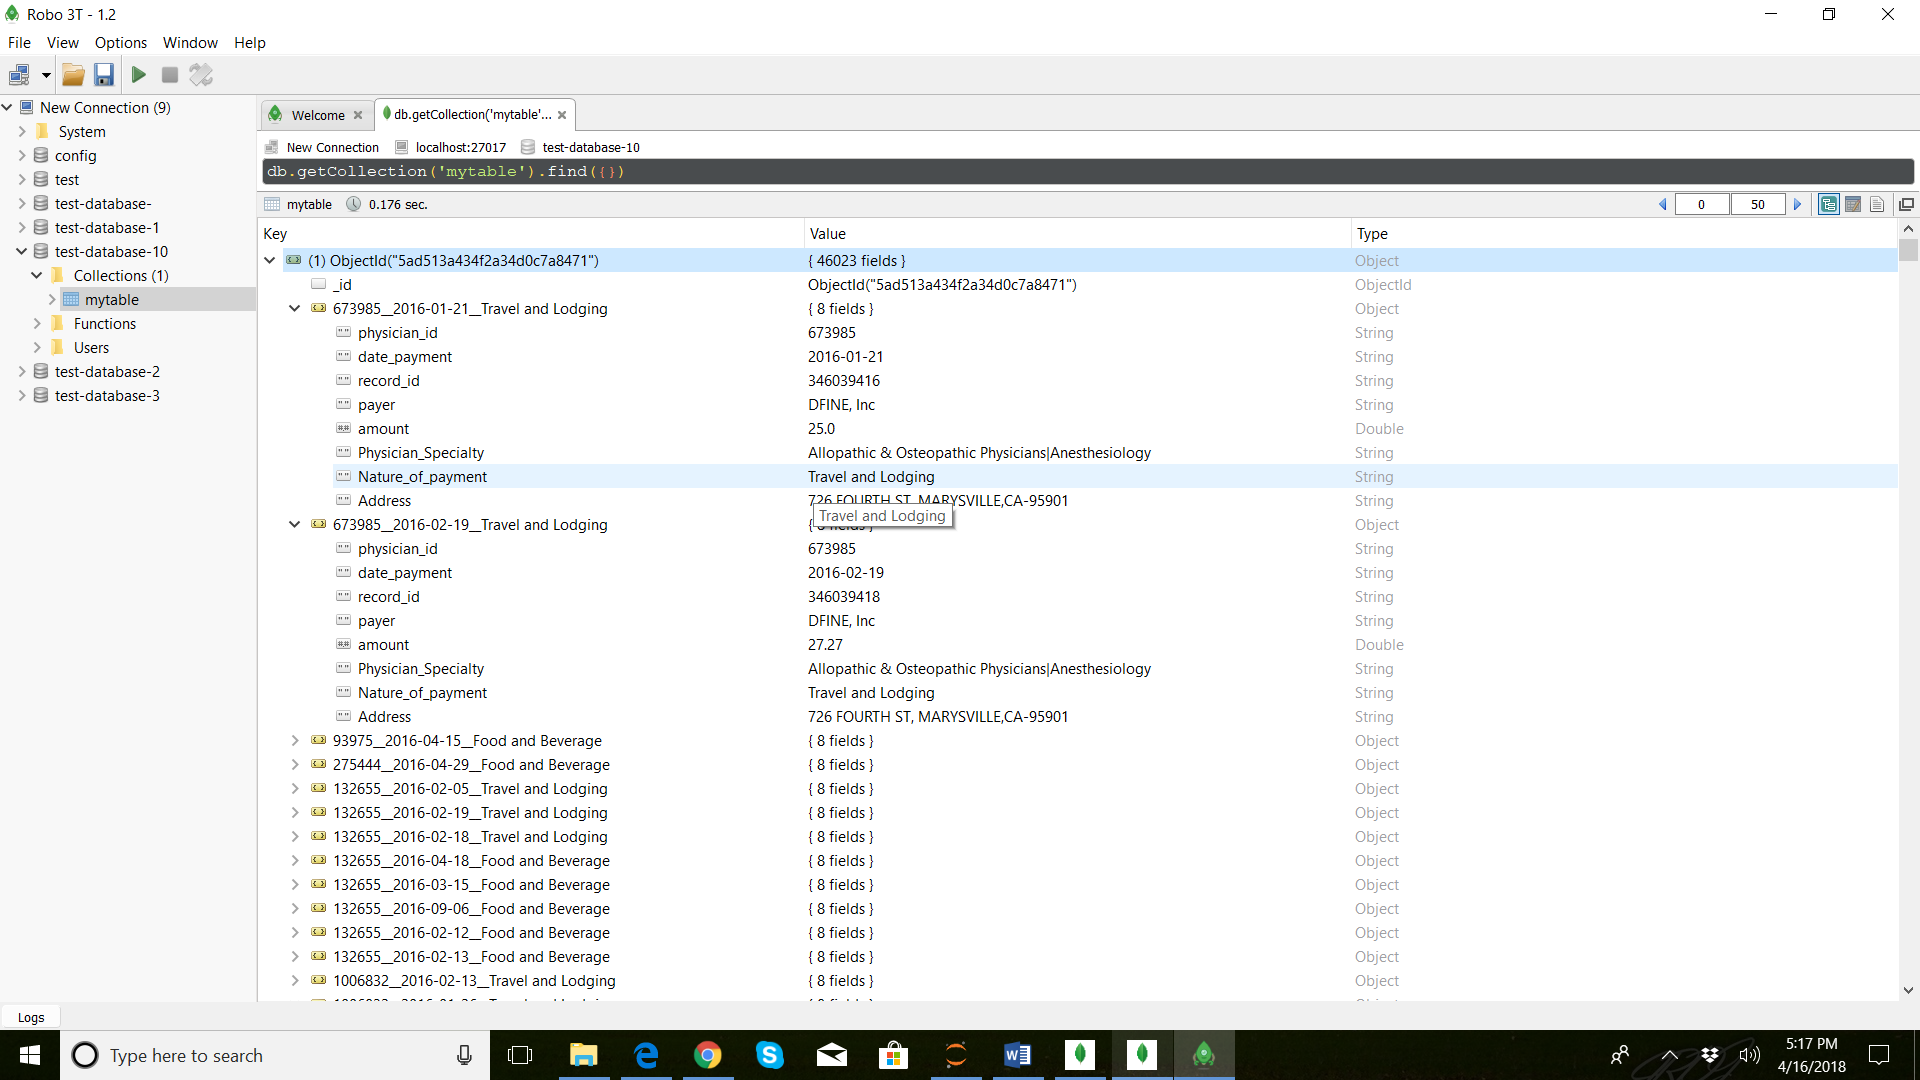

In [173]:
from IPython.display import Image
Image("Database.png")